In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds

In [4]:
df = pd.read_csv("ratings_Beauty.csv")
df

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200
...,...,...,...,...
2023065,A3DEHKPFANB8VA,B00LORWRJA,5.0,1405296000
2023066,A3DEHKPFANB8VA,B00LOS7MEE,5.0,1405296000
2023067,AG9TJLJUN5OM3,B00LP2YB8E,5.0,1405382400
2023068,AYBIB14QOI9PC,B00LPVG6V0,5.0,1405555200


In [8]:
df = df.drop('Timestamp', axis=1)
df

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0
2,A1Z513UWSAAO0F,0558925278,5.0
3,A1WMRR494NWEWV,0733001998,4.0
4,A3IAAVS479H7M7,0737104473,1.0
...,...,...,...
2023065,A3DEHKPFANB8VA,B00LORWRJA,5.0
2023066,A3DEHKPFANB8VA,B00LOS7MEE,5.0
2023067,AG9TJLJUN5OM3,B00LP2YB8E,5.0
2023068,AYBIB14QOI9PC,B00LPVG6V0,5.0


In [9]:
df2=df.copy(deep=True)
df2

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0
2,A1Z513UWSAAO0F,0558925278,5.0
3,A1WMRR494NWEWV,0733001998,4.0
4,A3IAAVS479H7M7,0737104473,1.0
...,...,...,...
2023065,A3DEHKPFANB8VA,B00LORWRJA,5.0
2023066,A3DEHKPFANB8VA,B00LOS7MEE,5.0
2023067,AG9TJLJUN5OM3,B00LP2YB8E,5.0
2023068,AYBIB14QOI9PC,B00LPVG6V0,5.0


In [11]:
df.shape

(2023070, 3)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 46.3+ MB


In [14]:
df.isna().sum()

UserId       0
ProductId    0
Rating       0
dtype: int64

In [16]:
df['Rating'].describe()

count    2.023070e+06
mean     4.149036e+00
std      1.311505e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [17]:
#RATING DISTRIBUTION

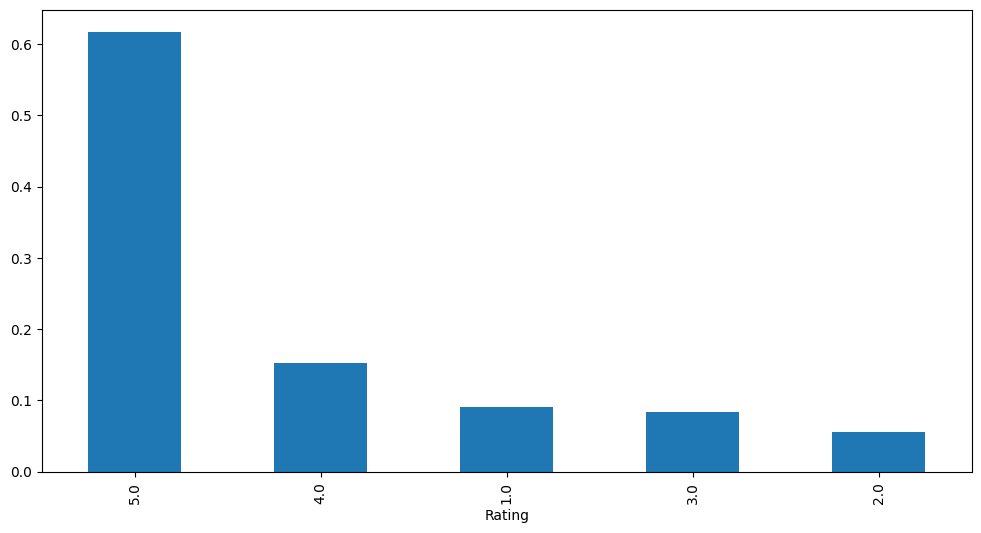

In [18]:
plt.figure(figsize=(12,6))
df['Rating'].value_counts(1).plot(kind='bar')
plt.show()

In [19]:
#Unique users present in the dataset

In [20]:
print("Unique Users:",df['UserId'].nunique())
print("Unique items:", df['ProductId'].nunique())

Unique Users: 1210271
Unique items: 249274


In [21]:
#Finding users with the most ratings


In [23]:
most_rated_users = df.groupby('UserId').size().sort_values(ascending=False)[:10]
most_rated_users

UserId
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
ALQGOMOY1F5X9     275
AKMEY1BSHSDG7     269
A3R9H6OKZHHRJD    259
A1M04H40ZVGWVG    249
A1RRMZKOMZ2M7J    225
dtype: int64

In [26]:
counts=df['UserId'].value_counts()
df_final = df[df['UserId'].isin(counts[counts >= 50].index)]

In [28]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['UserId'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['ProductId'].nunique())

The number of observations in the final data = 29559
Number of unique USERS in the final data =  361
Number of unique PRODUCTS in the final data =  17228


In [31]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (361, 17228)
given_num_of_ratings =  29559
possible_num_of_ratings =  6219308
density: 0.48%


ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y59HW4O47N0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A110PQTEI6THU7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:


#SINGULAR VALUE DECOMPOSITION



In [33]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)

In [34]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [35]:
U.shape

(361, 50)

In [36]:
Vt.shape

(50, 17228)

In [38]:


#Rating prediction



In [39]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

In [40]:
#Function to recommend ratings

In [41]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):
    
    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')
    
    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]   
    
    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


In [43]:


#Recommend top 5 products to user_id



In [44]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 121):

Recommended Products
12323    0.231035
4560     0.180850
5700     0.170876
7164     0.168580
361      0.167992
Name: user_predictions, dtype: float64


In [45]:
#recommend top 10 items 

In [46]:
recommend_items(100,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 100):

Recommended Products
14738    1.111167
14433    0.986382
14431    0.968452
14590    0.926752
3626     0.889151
12508    0.879329
14426    0.833219
14871    0.825405
12509    0.798574
14875    0.798140
Name: user_predictions, dtype: float64


In [47]:
#Evaluate the Model

In [48]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

ProductId
0762451459    0.01385
1304482596    0.00277
1304482685    0.00277
1304495396    0.00277
1304511111    0.00277
dtype: float64

In [50]:
preds_df.head()

ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
0,0.047090,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,0.000124,...,0.015907,0.015907,1.426274e-02,0.039624,0.031367,0.023621,0.015907,0.007613,0.100581,0.011551
1,0.000417,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,...,0.001455,0.001455,4.574687e-03,0.024927,0.002310,0.114070,0.001455,0.000406,0.028418,0.011666
2,0.004305,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,0.000128,...,0.001272,0.001272,9.245031e-03,0.010621,0.002462,0.002917,0.001272,0.007446,0.008230,0.021596
3,0.000094,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,0.000119,0.000119,7.511873e-07,0.000021,0.000225,0.000218,0.000119,0.000432,0.000316,0.000302
4,0.011773,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,0.000171,...,0.000615,0.000615,2.893702e-03,0.014905,0.001234,0.009558,0.000615,0.002654,0.016044,0.010468


In [51]:
avg_preds=preds_df.mean()
avg_preds.head()

ProductId
0762451459    0.043818
1304482596    0.000441
1304482685    0.000441
1304495396    0.000441
1304511111    0.000441
dtype: float64

In [52]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()
     

,Avg_actual_ratings,Avg_predicted_ratings
ProductId,,
0762451459,0.01385,0.043818
1304482596,0.00277,0.000441
1304482685,0.00277,0.000441
1304495396,0.00277,0.000441
1304511111,0.00277,0.000441


In [53]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')

RMSE SVD Model = 0.026487939760784406 

